In [308]:
import pandas, numpy

from skops.io import load

import matplotlib.pyplot as plt
import seaborn

from misc import construct_line

### Model validation on `test` set

We can now evaluate the trained models on the `test` dataset. As discussed in the manuscript we have two further datasets (`validation` & `mic`) to test the models on.

First let's load the trained models, the datasets and the results for Suspect-PZA


In [294]:
best_model = {}

for model in ['LR', 'NN', 'XB']:
    best_model[model] = load('models/'+model.lower()+'.skops', trusted=True)

X={}
Y={}
Z={}

for i in ['test','validation-samples', 'validation-mutations', 'mic']:
    X[i]={}
    Y[i]={}
    Z[i]={}
    with open('data/ds-'+i+'.npy', 'rb') as f:
        Y[i]['input'] = numpy.load(f)
        X[i]['input'] = numpy.load(f)
        Z[i]['input'] = numpy.load(f, allow_pickle=True)

# load in the results for SuspectPZA
suspectpza={}
for i in ['test', 'validation-samples', 'validation-mutations','mic']:
    suspectpza[i]={}
    with open('data/suspectpza-'+i+'.npy', 'rb') as f:
        suspectpza[i]['input'] = numpy.load(f)
        suspectpza[i]['predicted'] = numpy.load(f)
        suspectpza[i]['muts'] = numpy.load(f, allow_pickle=True)
line = []

For comparison later, let's make a subset of `validation-samples` that exclude those mutations which have an inconsistent phenotype, either because too few are in the dataset or they do not consistently test as R or S, suggesting they may be near the breakpoint/ECOFF. 

We need to do this for both the `validation-samples` features and the SuspectPZA results.

In [295]:
df = pandas.read_csv('data/ds-validation-mutations-full.csv')

mask = ~numpy.isin(Z['validation-samples']['input'], df[df.CONSISTENT_PHENOTYPE=='U'].MUTATION.unique())

X['validation-samples-noU']={}
Y['validation-samples-noU']={}
Z['validation-samples-noU']={}

X['validation-samples-noU']['input']=X['validation-samples']['input'][mask]
Y['validation-samples-noU']['input']=Y['validation-samples']['input'][mask]
Z['validation-samples-noU']['input']=Z['validation-samples']['input'][mask]

mask = ~numpy.isin(suspectpza['validation-samples']['muts'],(df[df.CONSISTENT_PHENOTYPE=='U'].MUTATION.unique()))
suspectpza['validation-samples-noU']={}
suspectpza['validation-samples-noU']['input']=suspectpza['validation-samples']['input'][mask]
suspectpza['validation-samples-noU']['predicted']=suspectpza['validation-samples']['predicted'][mask]
suspectpza['validation-samples-noU']['muts']=suspectpza['validation-samples']['muts'][mask]

The below function takes a supplied model, applies it to the features of the different datasets and measures a range of metrics we can use to evaluate their performance.

Note that this uses the separate `construct_line` function which can be found in `misc.py`.

In [296]:
def validate_model(line, best_model, model_name, X, Y):

    for dataset in ['test', 'validation-samples', 'validation-samples-noU', 'validation-mutations', 'mic']: 
        
        Y[dataset]['predicted'] = best_model.predict(X[dataset]['input'])
        Y[dataset]['scores'] = best_model.predict_proba(X[dataset]['input'])[:,1]

        row = construct_line(model_name , dataset, None, Y[dataset], None)
        line.append(row)

    return(line)

In [297]:
for model in ['LR', 'NN', 'XB']:
    line = validate_model(line, best_model[model], model, X, Y)

In [298]:
for i in ['test', 'validation-samples', 'validation-samples-noU', 'validation-mutations', 'mic']:
    line.append(construct_line('SP', i, None, suspectpza[i], None))

In [299]:
test_results = pandas.DataFrame(line, columns=['model', 'dataset', 'sensitivity_mean', 'sensitivity_std', 'specificity_mean', 'specificity_std' ,'roc_auc_mean', 'roc_auc_std','TN','FP','FN','TP', 'model_parameters'])

# calculate the diagnostic odds ration
test_results['diagnostic_odds_ratio_mean'] = (test_results['TN']*test_results['TP'])/(test_results['FN']*test_results['FP'])
test_results['diagnostic_odds_ratio_std'] = 0

# save to disc as a CSV
test_results.to_csv('results-test.csv', index=False)

test_results

,model,dataset,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,roc_auc_mean,roc_auc_std,TN,FP,FN,TP,model_parameters,diagnostic_odds_ratio_mean,diagnostic_odds_ratio_std
0,LR,test,78.640777,None,70.103093,None,82.684416,None,68,29,22,81,null,8.633229,0
1,LR,validation-samples,97.557471,None,43.845535,None,80.006802,None,545,698,68,2716,null,31.186162,0
2,LR,validation-samples-noU,98.615917,None,58.116481,None,85.212409,None,469,338,32,2280,null,98.864645,0
3,LR,validation-mutations,97.419355,None,50.000000,None,87.243402,None,22,22,4,151,null,37.750000,0
4,LR,mic,100.000000,None,14.285714,None,68.000000,None,1,6,0,50,null,inf,0
5,NN,test,76.699029,None,67.010309,None,79.861876,None,65,32,24,79,null,6.686198,0
6,NN,validation-samples,94.755747,None,48.833467,None,77.079895,None,607,636,146,2638,null,17.244615,0
7,NN,validation-samples-noU,96.237024,None,63.073110,None,82.534983,None,509,298,87,2225,null,43.682982,0
8,NN,validation-mutations,96.774194,None,52.272727,None,81.480938,None,23,21,5,150,null,32.857143,0
9,NN,mic,96.000000,None,28.571429,None,69.714286,None,2,5,2,48,null,9.600000,0


In [301]:
mics = pandas.read_csv('data/ds-mic-phen.csv')
mics.MIC.value_counts().sort_index()

0           1
0-25        2
100         2
200         2
200-300     1
300-400     1
600         1
600-800     2
75-100      2
800        18
>100       25
Name: MIC, dtype: int64

In [302]:
def assign_numerical_mic(row):
    if row.MIC=='>100':
        return(200)
    elif row.MIC=='75-100':
        return(100)
    elif row.MIC=='0-25':
        return(25)
    elif row.MIC=='600-800':
        return(800)
    elif row.MIC=='300-400':
        return(400)
    elif row.MIC=='200-300':
        return(300)
    else:
        return(int(row.MIC))
    
mics['numerical_mic'] = mics.apply(assign_numerical_mic, axis=1)

Ypred = best_model['XB'].predict(X['mic']['input'])
Yscores = best_model['XB'].predict_proba(X['mic']['input'])[:,1]

def find_score(row):
    mask = Z['mic']['input']==row.MUTATION
    return(Yscores[mask][0])

mics['score'] = mics.apply(find_score, axis=1)
    
mics[:3]

,MUTATION,CONSISTENT_PHENOTYPE,MIC,SOURCE,numerical_mic,score
0,V7G,R,800,CDC,800,0.965232
1,D8N,R,800,CDC,800,0.917857
2,Q10R,R,800,CDC,800,0.933346


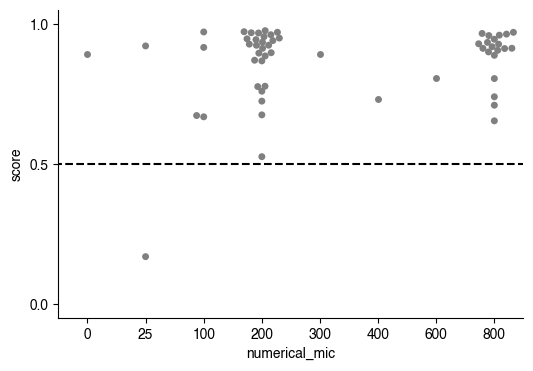

In [322]:
fig = plt.figure(figsize=(6, 4))
axes = seaborn.swarmplot(data=mics,y='score',x='numerical_mic', size=5, color='grey')
axes.plot([-50,800], [0.5,0.5], 'k--')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_yticks([0,0.5,1])
axes.plot([100,100], [0,1], 'k--')
fig.savefig('pdf/figure-5/fig-5-mic-swarm.pdf')

Let's look at the samples which have an MIC <= 100 µg/l which is the PZA MGIT breakpoint

In [324]:
mics[mics.CONSISTENT_PHENOTYPE=='S']

,MUTATION,CONSISTENT_PHENOTYPE,MIC,SOURCE,numerical_mic,score
4,F13C,S,75-100,EXIT-RIF,100,0.970575
11,L35R,S,75-100,EXIT-RIF,100,0.672123
29,C72G,S,0,EXIT-RIF,0,0.891759
30,F81S,S,100,CDC,100,0.667522
37,T114M,S,0-25,EXIT-RIF,25,0.168184
40,V130A,S,0-25,EXIT-RIF,25,0.920657
48,R140P,S,100,CDC,100,0.915461
